In [1]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

from time_series_influences.utils import split_time_series, match_train_time_block_index
from time_series_influences.influence_functions import compute_loo_linear_approx, empirical_IC_linear_approx
from time_series_influences.anomaly_detection import scale_influence_functions, eval_anomaly_detector

seed = 666
np.random.seed(seed)

In [2]:
data_path = "../data/univariate/UCR/data/"
data_dir = Path("../data/univariate/UCR/data/")
for file_name in os.listdir(data_path):
    if int(file_name[:3]) < 204:
        ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
        file_name_list = file_name[:-4].split('_')
        train_id, anomaly_start, anomaly_end = int(file_name_list[4]),int(file_name_list[5]),int(file_name_list[6])
        ts = ts.squeeze()
        ground_truth = np.zeros_like(ts)
        ground_truth[anomaly_start:anomaly_end] = 1.
        print('Dataset:',file_name_list[0]+'_'+file_name_list[3])
        print('Num. of Training: ',train_id)
        print('Num. of Test: ',len(ts)-train_id)
        print('Len. of Anomaly: ',anomaly_end-anomaly_start)
        print('Anomaly Ratio:', float((anomaly_end-anomaly_start))/len(ts))

Dataset: 183_qtdbSel100MLII
Num. of Training:  4000
Num. of Test:  26000
Len. of Anomaly:  400
Anomaly Ratio: 0.013333333333333334
Dataset: 194_sddb49
Num. of Training:  20000
Num. of Test:  60000
Len. of Anomaly:  250
Anomaly Ratio: 0.003125
Dataset: 069_DISTORTEDinsectEPG5
Num. of Training:  3200
Num. of Test:  6828
Len. of Anomaly:  1
Anomaly Ratio: 9.972078181092939e-05
Dataset: 023_DISTORTEDGP711MarkerLFM5z5
Num. of Training:  5000
Num. of Test:  7000
Len. of Anomaly:  104
Anomaly Ratio: 0.008666666666666666
Dataset: 180_ltstdbs30791ES
Num. of Training:  20000
Num. of Test:  35000
Len. of Anomaly:  200
Anomaly Ratio: 0.0036363636363636364
Dataset: 058_DISTORTEDapneaecg
Num. of Training:  10000
Num. of Test:  28501
Len. of Anomaly:  68
Anomaly Ratio: 0.0017661878912236047
Dataset: 130_GP711MarkerLFM5z4
Num. of Training:  4000
Num. of Test:  8000
Len. of Anomaly:  118
Anomaly Ratio: 0.009833333333333333
Dataset: 079_DISTORTEDresperation2
Num. of Training:  30000
Num. of Test:  17005

#### point outlier detection

In [3]:
file_name = "037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 17210, 17260
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

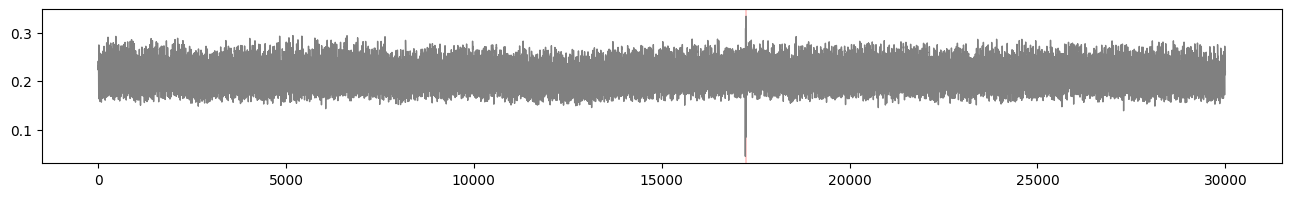

In [4]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.show()

In [5]:
block_length = 1
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(30000, 1) (30000,)


In [6]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [7]:
def empirical_IC_prop(x, y, X, beta, b, inv_hess):
    if len(beta.shape) == 2:
        n_series = beta.shape[0]
        block_length = beta.shape[1] // n_series
        grad = x.reshape(n_series, block_length) * (y - x.T @ beta.T - b).reshape(-1,1)
        eic = - (1/len(X)) * grad.flatten()
    else:
        eic = - (1/len(X)) * (x * (y - x.T @ beta - b))
    return eic

In [8]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(empirical_IC_prop(X_train[i], Y_train[i], X_train, beta, b, inv_hess))
time_block_loos = np.array(time_block_loos).squeeze()

Compute LOO: 100%|████████████████████| 30000/30000 [00:00<00:00, 192684.76it/s]


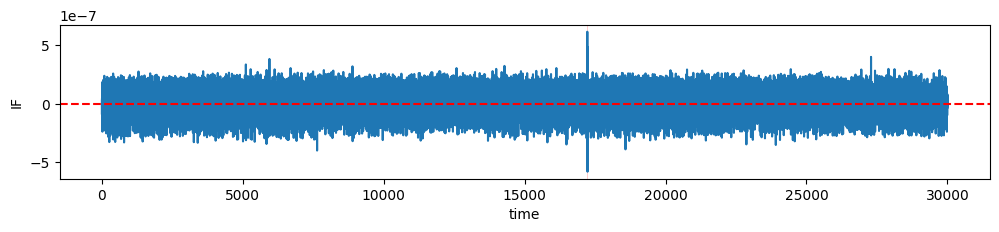

In [9]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_block_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [10]:
point_IF = time_block_loos.copy()[:2000]

In [11]:
def rhat(k, n, IF):
    return sum([IF[t]*IF[t+abs(k)] for t in range(1, n-abs(k))]) / n

In [12]:
w_TH = lambda x: (1 + np.cos(np.pi * x)) / 2 if abs(x) <= 1 else 0

In [13]:
def w_SC(x):
    if abs(x) <= 0.8:
        return 1
    elif (abs(x) <= 1) & (abs(x) > 0.8):
        return (1 + np.cos(5*np.pi * (x-0.8))) / 2
    else:
        return 0

In [17]:
def b_i(i, b, n):
    assert i in [1, 2, 3, 4]
    num = sum([rhat(k, n, point_IF)**2 for k in range(1-n, n-1)])
    denom = 6 * sum([(w_SC(k*b[i-1]*np.power(n, 4/21))**2)*(k**2)*(rhat(k, n, point_IF)**2) for k in range(1-n, n-1)])
    print(num, denom)
    return np.power(n, -1/3) * np.power(num/denom, 1/3)

def calc_b(b4, n):
    num = 2 * sum([w_TH(k*b4*np.power(n, 4/21))*rhat(k, n, point_IF) for k in range(1-n, n-1)]) ** 2
    denom = 3 * sum([w_SC(k*b4*np.power(n, 4/21))*abs(k)*rhat(k, n, point_IF) for k in range(1-n, n-1)]) ** 2
    print(num, denom)
    return np.power(n, -1/3) * np.power(num/denom, 1/3)

In [18]:
n = len(point_IF)
b0 = 1/n
b1 = b_i(1, [b0], n)
b2 = b_i(2, [b0, b1], n)
b3 = b_i(3, [b0, b1, b2], n)
b4 = b_i(4, [b0, b1, b2, b3], n)

6.965615415319951e-28 6.384303070267666e-23
6.965615415319951e-28 2.9762809903193826e-24
6.965615415319951e-28 7.7151215392442025e-25
6.965615415319951e-28 2.1599303849226126e-26


In [19]:
b4

0.02526367821023856

In [21]:
calc_b(b4, n)

1.2766589629014107e-28 9.253713497909507e-27


0.01903602579166832

In [23]:
block_length = int(1/calc_b(b4, n))
print(block_length)

1.2766589629014107e-28 9.253713497909507e-27
52


In [24]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(29949, 52) (29949,)


In [25]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [26]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 29949/29949 [00:00<00:00, 73944.85it/s]


In [27]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

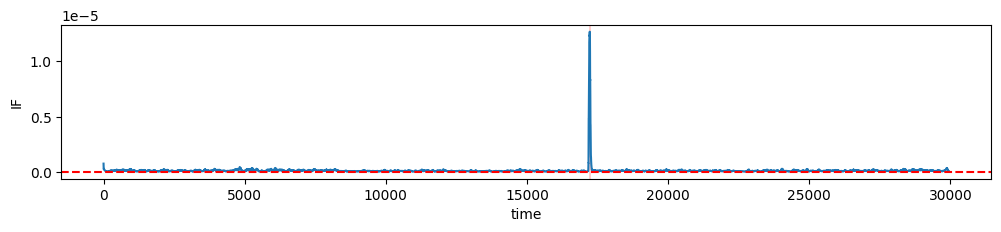

In [28]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [29]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length=block_length)

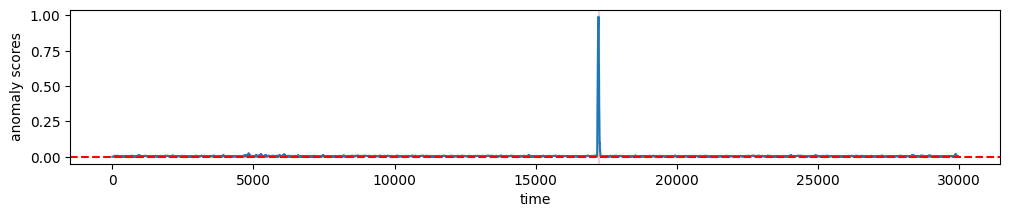

In [30]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [31]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

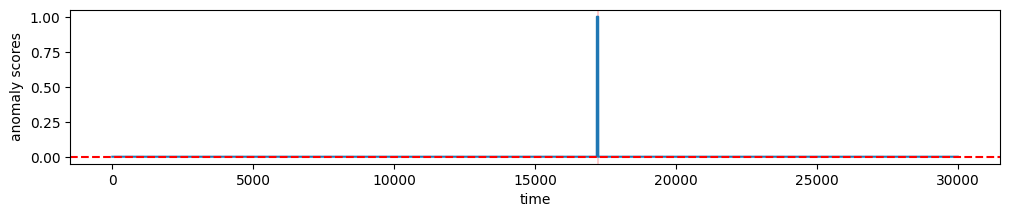

In [32]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [33]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.640 recall: 0.640 F1: 0.640 AUC: 1.000


#### change point detection

In [34]:
file_name = "042_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG6_7000_12190_12420.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 12190, 12420
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

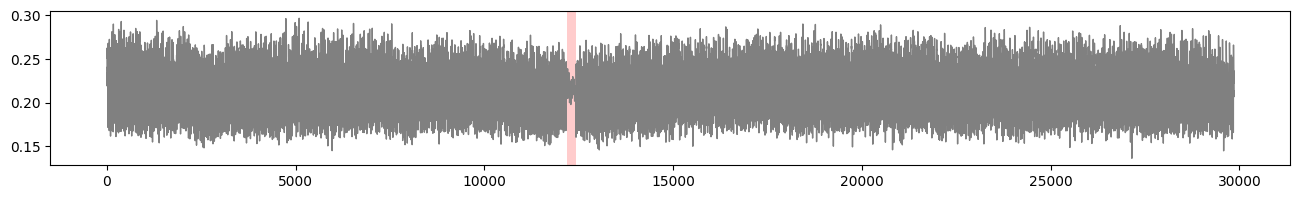

In [35]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.show()

In [36]:
block_length = 1
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(29858, 1) (29858,)


In [37]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [38]:
def empirical_IC_prop(x, y, X, beta, b, inv_hess):
    if len(beta.shape) == 2:
        n_series = beta.shape[0]
        block_length = beta.shape[1] // n_series
        grad = x.reshape(n_series, block_length) * (y - x.T @ beta.T - b).reshape(-1,1)
        eic = - (1/len(X)) * grad.flatten()
    else:
        eic = - (1/len(X)) * (x * (y - x.T @ beta - b))
    return eic

In [39]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(empirical_IC_prop(X_train[i], Y_train[i], X_train, beta, b, inv_hess))
time_block_loos = np.array(time_block_loos).squeeze()

Compute LOO: 100%|████████████████████| 29858/29858 [00:00<00:00, 175522.96it/s]


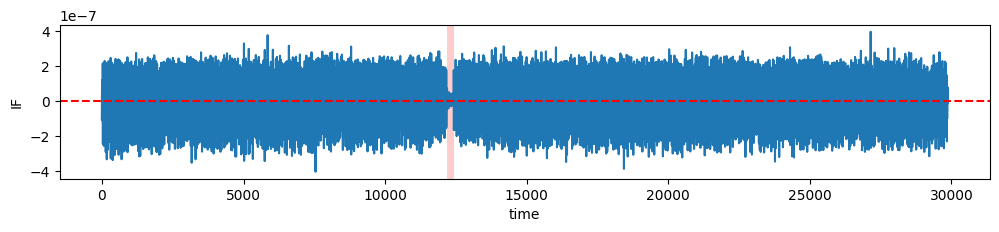

In [40]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_block_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [41]:
point_IF = time_block_loos.copy()[:2000]

In [42]:
def rhat(k, n, IF):
    return sum([IF[t]*IF[t+abs(k)] for t in range(1, n-abs(k))]) / n

In [43]:
w_TH = lambda x: (1 + np.cos(np.pi * x)) / 2 if abs(x) <= 1 else 0

In [44]:
def w_SC(x):
    if abs(x) <= 0.8:
        return 1
    elif (abs(x) <= 1) & (abs(x) > 0.8):
        return (1 + np.cos(5*np.pi * (x-0.8))) / 2
    else:
        return 0

In [45]:
def b_i(i, b, n):
    assert i in [1, 2, 3, 4]
    num = sum([rhat(k, n, point_IF)**2 for k in range(1-n, n-1)])
    denom = 6 * sum([(w_SC(k*b[i-1]*np.power(n, 4/21))**2)*(k**2)*(rhat(k, n, point_IF)**2) for k in range(1-n, n-1)])
    print(num, denom)
    return np.power(n, -1/3) * np.power(num/denom, 1/3)

def calc_b(b4, n):
    num = 2 * sum([w_TH(k*b4*np.power(n, 4/21))*rhat(k, n, point_IF) for k in range(1-n, n-1)]) ** 2
    denom = 3 * sum([w_SC(k*b4*np.power(n, 4/21))*abs(k)*rhat(k, n, point_IF) for k in range(1-n, n-1)]) ** 2
    print(num, denom)
    return np.power(n, -1/3) * np.power(num/denom, 1/3)

In [46]:
n = len(point_IF)
b0 = 1 / n
b1 = b_i(1, [b0], n)
b2 = b_i(2, [b0, b1], n)
b3 = b_i(3, [b0, b1, b2], n)
b4 = b_i(4, [b0, b1, b2, b3], n)

6.915444868782143e-28 6.072886441530007e-23
6.915444868782143e-28 2.8778413839719704e-24
6.915444868782143e-28 7.821880074082168e-25
6.915444868782143e-28 2.4435217288072936e-26


In [47]:
b4

0.024187518106705615

In [48]:
calc_b(b4, n)

1.1128968794887612e-28 9.870085895457634e-27


0.017797868716893234

In [49]:
block_length = int(1/calc_b(b4, n))
print(block_length)

1.1128968794887612e-28 9.870085895457634e-27
56


In [50]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(29803, 56) (29803,)


In [51]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [52]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 29803/29803 [00:00<00:00, 72725.37it/s]


In [53]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

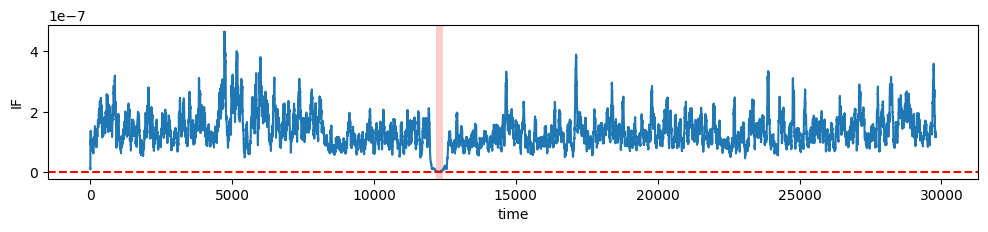

In [54]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [55]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

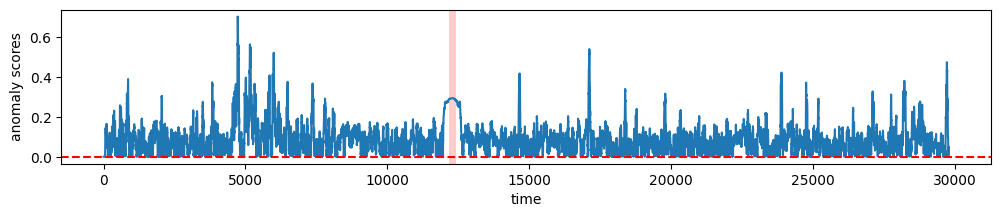

In [56]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [57]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

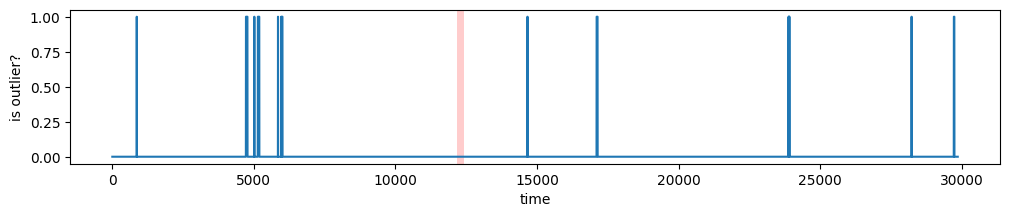

In [58]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [59]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.000 recall: 0.000 F1: 0.000 AUC: 0.978


#### anomaly pattern detection

In [60]:
file_name = "062_UCR_Anomaly_DISTORTEDgaitHunt1_18500_33070_33180.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 33070, 33180
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

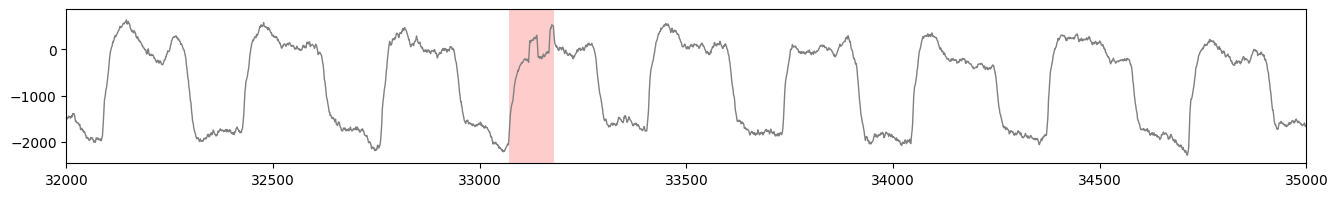

In [61]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.xlim(32000, 35000)
plt.show()

In [62]:
block_length = 1
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(63999, 1) (63999,)


In [63]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [64]:
def empirical_IC_prop(x, y, X, beta, b, inv_hess):
    if len(beta.shape) == 2:
        n_series = beta.shape[0]
        block_length = beta.shape[1] // n_series
        grad = x.reshape(n_series, block_length) * (y - x.T @ beta.T - b).reshape(-1,1)
        eic = - (1/len(X)) * grad.flatten()
    else:
        eic = - (1/len(X)) * (x * (y - x.T @ beta - b))
    return eic

In [65]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(empirical_IC_prop(X_train[i], Y_train[i], X_train, beta, b, inv_hess))
time_block_loos = np.array(time_block_loos).squeeze()

Compute LOO: 100%|████████████████████| 63999/63999 [00:00<00:00, 200961.61it/s]


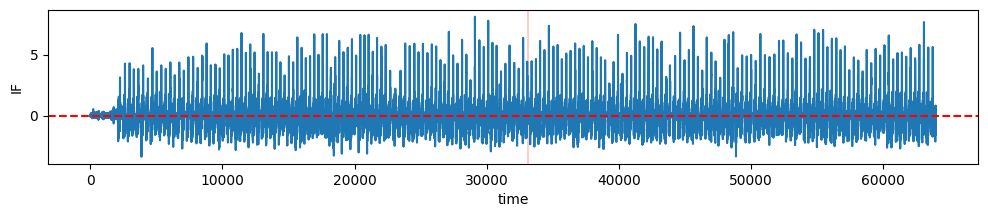

In [66]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_block_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [67]:
point_IF = time_block_loos.copy()[10000:12000]

In [68]:
def rhat(k, n, IF):
    return sum([IF[t]*IF[t+abs(k)] for t in range(1, n-abs(k))]) / n

In [69]:
w_TH = lambda x: (1 + np.cos(np.pi * x)) / 2 if abs(x) <= 1 else 0

In [70]:
def w_SC(x):
    if abs(x) <= 0.8:
        return 1
    elif (abs(x) <= 1) & (abs(x) > 0.8):
        return (1 + np.cos(5*np.pi * (x-0.8))) / 2
    else:
        return 0

In [71]:
def b_i(i, b, n):
    assert i in [1, 2, 3, 4]
    num = sum([rhat(k, n, point_IF)**2 for k in range(1-n, n-1)])
    denom = 6 * sum([(w_SC(k*b[i-1]*np.power(n, 4/21))**2)*(k**2)*(rhat(k, n, point_IF)**2) for k in range(1-n, n-1)])
    print(num, denom)
    return np.power(n, -1/3) * np.power(num/denom, 1/3)

def calc_b(b4, n):
    num = 2 * sum([w_TH(k*b4*np.power(n, 4/21))*rhat(k, n, point_IF) for k in range(1-n, n-1)]) ** 2
    denom = 3 * sum([w_SC(k*b4*np.power(n, 4/21))*abs(k)*rhat(k, n, point_IF) for k in range(1-n, n-1)]) ** 2
    print(num, denom)
    return np.power(n, -1/3) * np.power(num/denom, 1/3)

In [72]:
n = len(point_IF)
b0 = 1 / n
b1 = b_i(1, [b0], n)
b2 = b_i(2, [b0, b1], n)
b3 = b_i(3, [b0, b1, b2], n)
b4 = b_i(4, [b0, b1, b2, b3], n)

5.550112778870607 765553.8254708042
5.550112778870607 28940.93417865492
5.550112778870607 289.76833823926825
5.550112778870607 80.41936352370612


In [73]:
b4

0.032556451316585

In [74]:
calc_b(b4, n)

9.92704163477618 205.55111890490122


0.028903914740689294

In [75]:
block_length = int(1/calc_b(b4, n))
print(block_length)

9.92704163477618 205.55111890490122
34


In [76]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(63966, 34) (63966,)


In [77]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [78]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 63966/63966 [00:00<00:00, 83770.44it/s]


In [79]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

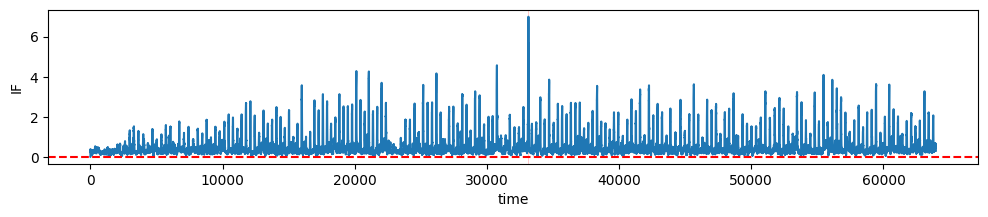

In [80]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [81]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

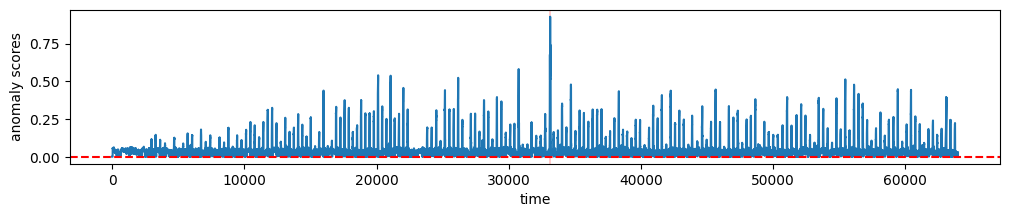

In [82]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [83]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

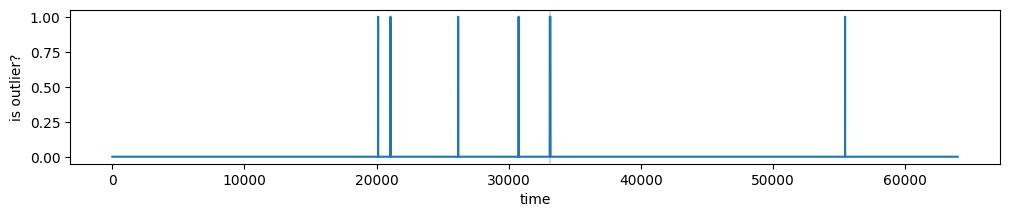

In [84]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [85]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.555 recall: 0.555 F1: 0.555 AUC: 0.888


#### noise detection

In [86]:
file_name = "003_UCR_Anomaly_DISTORTED3sddb40_35000_46600_46900.txt"
ts = pd.read_csv(data_dir/file_name, delimiter='\t', header=None).to_numpy()
ts = ts.squeeze()
anomaly_start, anomaly_end = 46600, 46900
ground_truth = np.zeros_like(ts)
ground_truth[anomaly_start:anomaly_end] = 1.

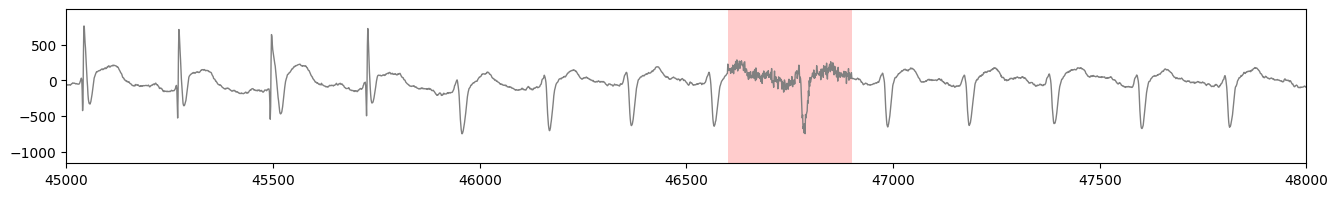

In [87]:
plt.figure(figsize=(16,2))
plt.plot(ts, c="gray", linewidth=1)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.xlim(45000, 48000)
plt.show()

In [88]:
block_length = 1
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(79999, 1) (79999,)


In [89]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [90]:
def empirical_IC_prop(x, y, X, beta, b, inv_hess):
    if len(beta.shape) == 2:
        n_series = beta.shape[0]
        block_length = beta.shape[1] // n_series
        grad = x.reshape(n_series, block_length) * (y - x.T @ beta.T - b).reshape(-1,1)
        eic = - (1/len(X)) * grad.flatten()
    else:
        eic = - (1/len(X)) * (x * (y - x.T @ beta - b))
    return eic

In [91]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(empirical_IC_prop(X_train[i], Y_train[i], X_train, beta, b, inv_hess))
time_block_loos = np.array(time_block_loos).squeeze()

Compute LOO: 100%|████████████████████| 79999/79999 [00:00<00:00, 203963.61it/s]


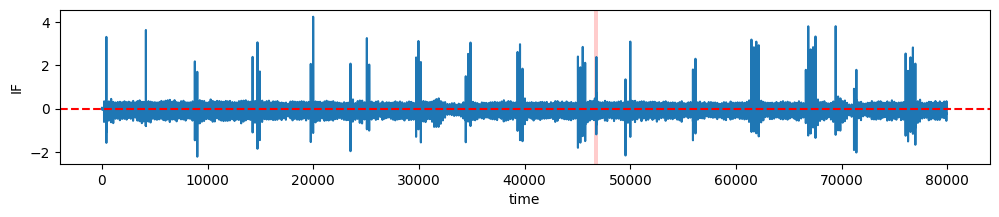

In [92]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_block_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [93]:
point_IF = time_block_loos.copy()[47000:49000]

In [94]:
def rhat(k, n, IF):
    return sum([IF[t]*IF[t+abs(k)] for t in range(1, n-abs(k))]) / n

In [95]:
w_TH = lambda x: (1 + np.cos(np.pi * x)) / 2 if abs(x) <= 1 else 0

In [96]:
def w_SC(x):
    if abs(x) <= 0.8:
        return 1
    elif (abs(x) <= 1) & (abs(x) > 0.8):
        return (1 + np.cos(5*np.pi * (x-0.8))) / 2
    else:
        return 0

In [97]:
def b_i(i, b, n):
    assert i in [1, 2, 3, 4]
    num = sum([rhat(k, n, point_IF)**2 for k in range(1-n, n-1)])
    denom = 6 * sum([(w_SC(k*b[i-1]*np.power(n, 4/21))**2)*(k**2)*(rhat(k, n, point_IF)**2) for k in range(1-n, n-1)])
    print(num, denom)
    return np.power(n, -1/3) * np.power(num/denom, 1/3)

def calc_b(b4, n):
    num = 2 * sum([w_TH(k*b4*np.power(n, 4/21))*rhat(k, n, point_IF) for k in range(1-n, n-1)]) ** 2
    denom = 3 * sum([w_SC(k*b4*np.power(n, 4/21))*abs(k)*rhat(k, n, point_IF) for k in range(1-n, n-1)]) ** 2
    print(num, denom)
    return np.power(n, -1/3) * np.power(num/denom, 1/3)

In [98]:
n = len(point_IF)
b0 = 1 / n
b1 = b_i(1, [b0], n)
b2 = b_i(2, [b0, b1], n)
b3 = b_i(3, [b0, b1, b2], n)
b4 = b_i(4, [b0, b1, b2, b3], n)

0.0006356587205955295 44.11127144386178
0.0006356587205955295 0.07873510859037483
0.0006356587205955295 0.04197502280089343
0.0006356587205955295 0.019749218678266248


In [99]:
b4

0.025247285920421057

In [100]:
calc_b(b4, n)

0.0024257190926911527 0.0033624736782790626


0.0711842432560223

In [101]:
block_length = int(1/calc_b(b4, n))
print(block_length)

0.0024257190926911527 0.0033624736782790626
14


In [102]:
X_train, Y_train = split_time_series(ts, block_length=block_length)
matched_block_idxs = match_train_time_block_index(ts, X_train)
print(X_train.shape, Y_train.shape)

(79986, 14) (79986,)


In [103]:
lr = LinearRegression().fit(X_train, Y_train)
beta = lr.coef_
b = lr.intercept_
inv_hess = len(X_train) * np.linalg.inv(X_train.T @ X_train)
params = (beta, b, inv_hess)

In [104]:
# compute IF for each time block
time_block_loos = []
for i in tqdm(range(len(X_train)), total=len(X_train), desc="Compute LOO"):
  time_block_loos.append(compute_loo_linear_approx(i, i, X_train, Y_train, X_train, Y_train, params))
time_block_loos = np.array(time_block_loos)

Compute LOO: 100%|█████████████████████| 79986/79986 [00:00<00:00, 81997.15it/s]


In [105]:
# compute IF for each time point
time_point_loos = []
for i in range(len(matched_block_idxs)):
  time_point_loos.append((time_block_loos[matched_block_idxs[i]]).mean())
time_point_loos = np.array(time_point_loos)

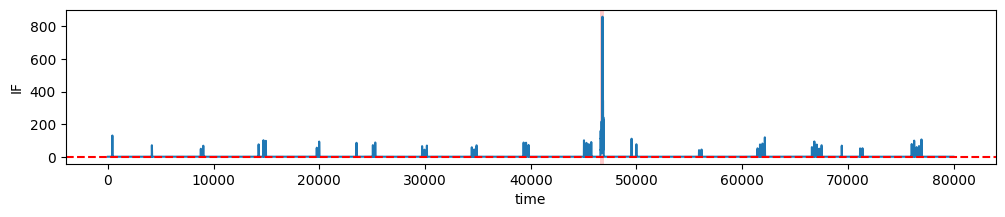

In [106]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = time_point_loos
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("IF")
plt.xlabel("time")
plt.show()

In [107]:
anomaly_scores = scale_influence_functions(time_point_loos, block_length)

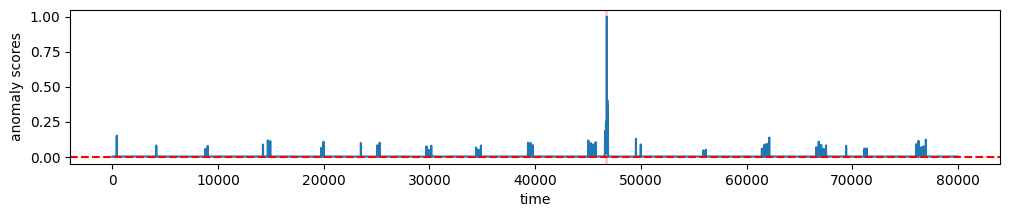

In [108]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(X_train)] = anomaly_scores
plt.plot(loos_viz)
plt.axhline(y=0, c="r", linestyle="--")
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("anomaly scores")
plt.xlabel("time")
plt.show()

In [109]:
contam_ratio = (anomaly_end - anomaly_start) / len(ts)
detected_outliers = np.zeros_like(ts)
detected_outliers[:len(anomaly_scores)] = anomaly_scores > np.quantile(anomaly_scores, 1-contam_ratio)

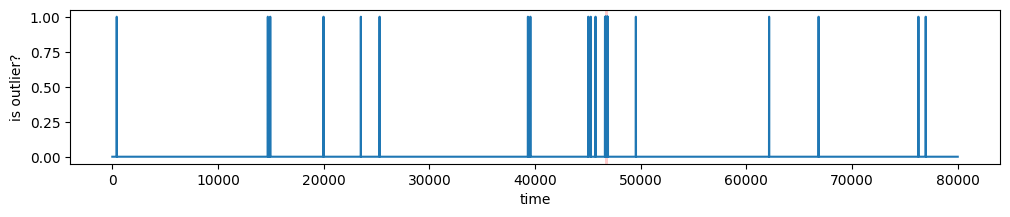

In [110]:
plt.figure(figsize=(12,2))
loos_viz = np.ones_like(ts) * np.nan
loos_viz[:len(detected_outliers)] = detected_outliers
plt.plot(loos_viz)
plt.axvspan(anomaly_start, anomaly_end, facecolor='red', alpha=.2)
plt.ylabel("is outlier?")
plt.xlabel("time")
plt.show()

In [111]:
prec, rec, f1, _ = eval_anomaly_detector(ground_truth[:len(anomaly_scores)], detected_outliers[:len(anomaly_scores)], anomaly_scores)

precision: 0.527 recall: 0.527 F1: 0.527 AUC: 0.997
